## DQN Tester

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from collections import Counter

In [3]:
my_device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
class DNN(nn.Module):
    def __init__(self, input_units, output_units):
        super(DNN, self).__init__()
        self.layer1 = nn.Linear(input_units, 100, dtype=torch.float64, device=my_device)
        self.layer2 = nn.Linear(100, 100, dtype=torch.float64, device=my_device)
        self.layer3 = nn.Linear(100, output_units, dtype=torch.float64, device=my_device)

    def forward(self, x):
        hidden1 = F.relu(self.layer1(x))
        hidden2 = F.relu(self.layer2(hidden1))
        return F.softmax(self.layer3(hidden2), dim=-1)

In [5]:
class DQNTester:
    def __init__(self, features: pd.DataFrame, label: str, model_pth):
        self.df_x = features
        self.y = label['class']
        self.model_path = model_pth
        self.data = torch.from_numpy(self.df_x.values).to(my_device)
        self.model = self.load_model()
        self.preds = torch.argmax(self.model(self.data), axis=1)
        self.preds = self.preds.cpu().numpy() if my_device=="cuda" else self.preds

    def load_model(self):
        check_point = torch.load(self.model_path)
        model = DNN(self.df_x.shape[1], self.y.nunique())
        model.load_state_dict(check_point["state_dict"])
        return model

    def get_weighted_accuracy(self):
        class_accuracies = []
        supports = []
        for class_ in self.y.unique():
            idx = np.where(self.y == class_)
            class_accuracy = accuracy_score(self.y[idx[0]], self.preds[idx[0]])
            class_accuracies.append(class_accuracy)
            supports.append(len(idx[0]))

        class_accuracies = np.array(class_accuracies)
        supports = np.array(supports)
        return np.average(class_accuracies, weights=supports)

    def generate_confusion_matrix(self):
        cm = pd.DataFrame(data=confusion_matrix(self.y, self.preds), 
                          index = ['U2R', 'R2L', 'Probe', 'DoS', 'Normal'],
                          columns = ['U2R', 'R2L', 'Probe', 'DoS', 'Normal'])

        plt.figure(figsize=(5, 4))
        sns.heatmap(data=cm, annot=True, fmt=".0f", cmap='Blues')
        plt.title("Confusion Matrix", weight='bold')
        plt.xlabel("Predicted Labels", weight='bold')
        plt.ylabel("True Labels", weight='bold')
        plt.savefig("matrix.png")
        plt.show()

    def generate_evaluation_metrics(self):
        accuracy = accuracy_score(self.y, self.preds)
        weighted_accuracy = self.get_weighted_accuracy()

        # Macro: Average of F1 scores of each class!
        macro_f1 = f1_score(self.y, self.preds, average='macro')
        macro_precision = precision_score(self.y, self.preds, average='macro')
        macro_recall = recall_score(self.y, self.preds, average='macro')

        # Weighted: Weighted Average of F1 Scores of each class!
        weighted_f1 = f1_score(self.y, self.preds, average='weighted')
        weighted_precision = precision_score(self.y, self.preds, average='weighted')
        weighted_recall = recall_score(self.y, self.preds, average='weighted')
        
        metrics = np.array([[accuracy, macro_precision, macro_recall, macro_f1], 
                            [weighted_accuracy, weighted_precision, weighted_recall, weighted_f1]])

        results = pd.DataFrame(data=metrics, index = ['Macro', 'Weighted'],
                               columns=['Accuracy', 'Precision', "Recall", 'F1 Score'])
        
        return results

In [6]:
X_test = pd.read_csv("X_test.csv")
y_test = pd.read_csv("y_test.csv")
tester = DQNTester(features=X_test, label=y_test, model_pth="Models/DQN.pth")

In [7]:
tester.generate_evaluation_metrics()

,Accuracy,Precision,Recall,F1 Score
Macro,0.976843,0.751594,0.698547,0.718992
Weighted,0.976843,0.977868,0.976843,0.976556


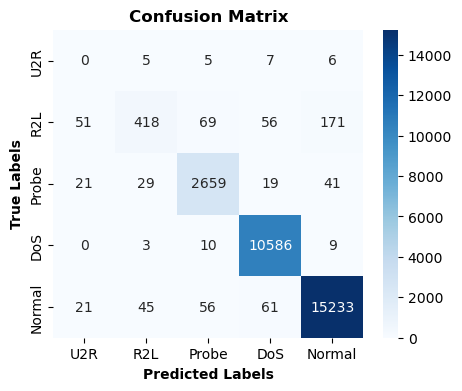

In [8]:
tester.generate_confusion_matrix()

In [9]:
y_test.value_counts()

class
4        15416
3        10608
2         2769
1          765
0           23
Name: count, dtype: int64

In [10]:
Counter(tester.preds)

Counter({4: 15460, 3: 10729, 2: 2799, 1: 500, 0: 93})